# Sampling (hierarchical and non-hierarchical)
The point of this notebook is to walk the user through a numpyro-based comparitive analysis of a hierarchical model and one non-hierarchical multilevel model (unpooled). This notebook will use the static dataset method to import a pre-saved dataset.

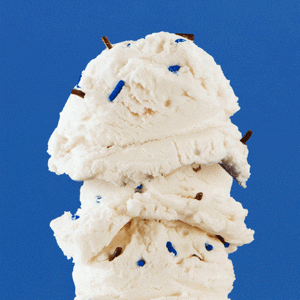

Hierarchical models are like ice cream; each layer of stack mixes with the other layers, lending them inference power. This notebook steps out to demonstrate empirically that hierarchical models are more powerful and here we carry out a careful treatment of the uncertainty quantification.

In [33]:
## first, import all the necessary modules
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
print(numpyro.__version__)

## define the platform and number of cores (one chain per core)
numpyro.set_platform('cpu')
core_num = 4
numpyro.set_host_device_count(core_num)

from numpyro.infer import MCMC, NUTS
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import deepbench
from deepbench.physics_object import Pendulum

0.13.2


In [2]:
# this is necessary to import modules from this repo
import sys
sys.path.append('..')
from src.scripts import models, utils

## Load data from a saved csv
This dataset has been prepared using the `save_dataframe.ipynb` notebook.

In [19]:
# load the dataframe
filepath = '../data/'
df = pd.read_csv(filepath+'static_hierarchical_df.csv')[['length','theta','a_g','time','pos','pos_err']]

In [20]:
df

,length,theta,a_g,time,pos,pos_err
0,5.939540,0.040323,10.348500,0.75,0.126648,0.013138
1,3.645948,0.041587,10.348500,0.75,0.046904,0.004585
2,4.494573,0.032681,10.348500,0.75,0.066548,0.006160
3,3.691717,0.032449,10.348500,0.75,0.036753,0.003712
4,8.463276,0.026023,10.348500,0.75,0.124928,0.014872
...,...,...,...,...,...,...
95,3.287364,0.027606,9.821157,0.75,0.027284,0.002459
96,4.901377,0.031559,9.821157,0.75,0.080431,0.007539
97,6.374146,0.028311,9.821157,0.75,0.102336,0.010773
98,1.075661,0.030635,9.821157,0.75,-0.023095,0.002111


## Add some necessary information for sampling inference
This includes some identifier columns for planet and pendulum number. In this case, there are two planets and 50 pendulums per planet. Planet is therefore indexed either 0 or 1 and pendulum is indexed 0 ...99.

In [21]:
# there are 2 planets
df['planet_code'] = df['a_g'].apply(lambda x: 0 if x == df['a_g'][0] else 1)
# there are 100 unique pendulums
df['pendulum_code'] = pd.factorize(df['length'])[0]
df

,length,theta,a_g,time,pos,pos_err,planet_code,pendulum_code
0,5.939540,0.040323,10.348500,0.75,0.126648,0.013138,0,0
1,3.645948,0.041587,10.348500,0.75,0.046904,0.004585,0,1
2,4.494573,0.032681,10.348500,0.75,0.066548,0.006160,0,2
3,3.691717,0.032449,10.348500,0.75,0.036753,0.003712,0,3
4,8.463276,0.026023,10.348500,0.75,0.124928,0.014872,0,4
...,...,...,...,...,...,...,...,...
95,3.287364,0.027606,9.821157,0.75,0.027284,0.002459,1,95
96,4.901377,0.031559,9.821157,0.75,0.080431,0.007539,1,96
97,6.374146,0.028311,9.821157,0.75,0.102336,0.010773,1,97
98,1.075661,0.030635,9.821157,0.75,-0.023095,0.002111,1,98


Let's just visualize this a little bit.

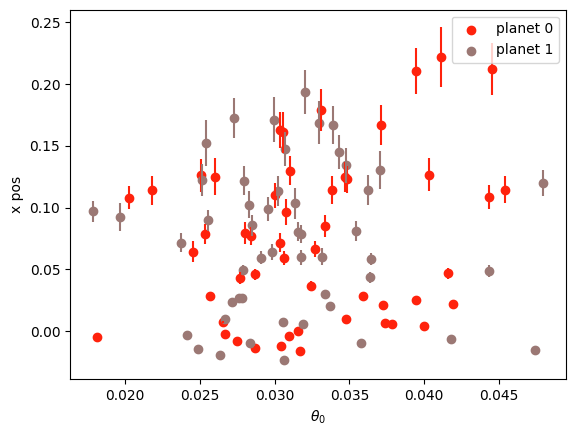

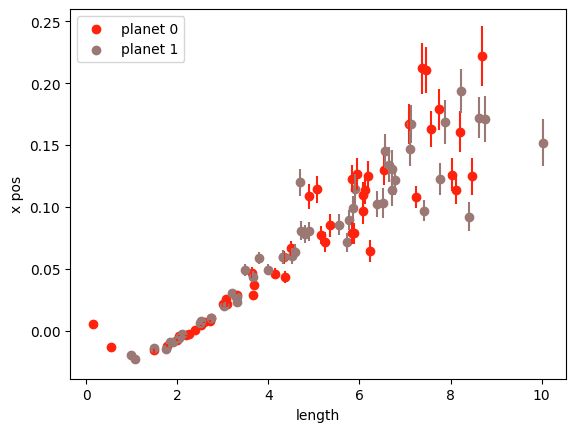

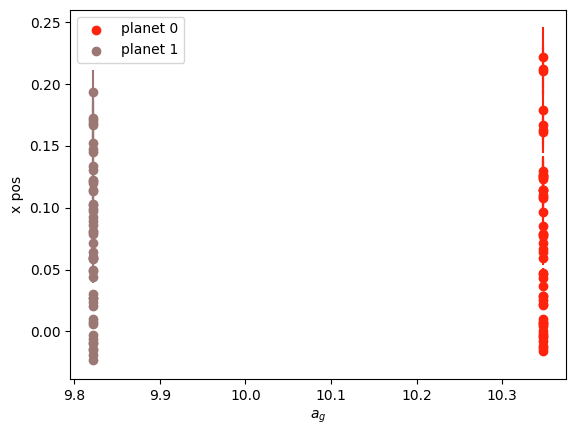

In [22]:
utils.plot_df(df)

## Hierarchical model
Again, this is the full ice cream stack model. Here, there are global values (μ_a_g and σ_a_g), from which the individual a_g values are drawn for each planet. The a_g values get information from all pendulums on a given planet AND from the global values which also are informed by the pendulums on the other planet. The L and theta are sampled for each individual planet.

Note that there is an error component (sigma) so we can directly model the overall error; this could eventually become sigma on every individual parameter.

In [23]:
exponential = 100

In [24]:
def hierarchical_model(planet_code, pend_code, times, exponential, pos_obs=None):
    models.hierarchical_model(planet_code, pend_code, times, exponential, pos_obs=None)

## Now non-hierarchical setup
There are many types of non-hierarchical setups. Here, we'll focus on a non-hierarchical setup that is multilevel. This type of model is called a "no pooling model". In a no pooling model, the a_g value is sampled for each planet individually without any uniting global variables). The model is still multi-level because the parameters are organized according to the groupings.

The unpooled model is like a bunch of different ice cream cones:

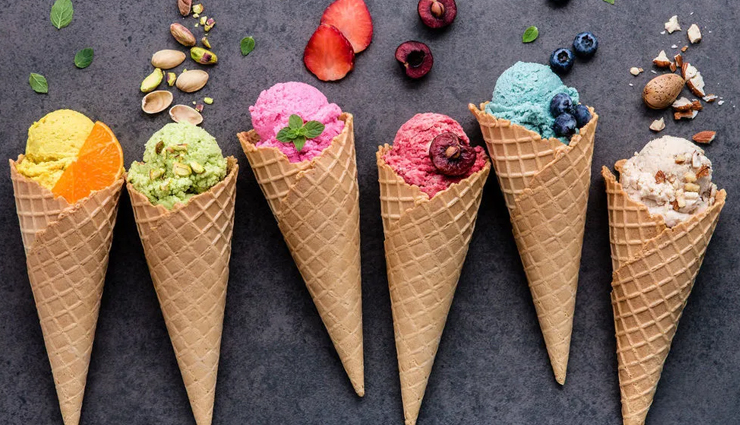

Here, the modeling is fully segmented for each planet (here, ice cream cone). This means the model has no mechanism (such as a global distribution characterized by μ_a_g and σ_a_g) to share information between groups.

In [25]:
def unpooled_model(planet_code, pend_code, times, exponential, pos_obs=None):
    unpooled_model = models.unpooled_model(planet_code, pend_code, times, exponential, pos_obs=None)

## Visualize the probabilistic graph models for the above models
Numpyro has some neat tools for creating DAGS - directive acyclic graphs

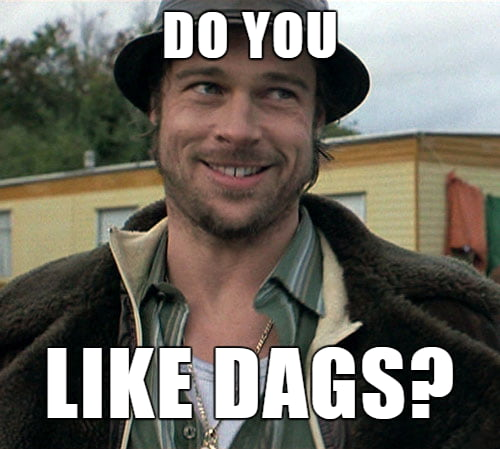

<function hierarchical_model at 0x2b2f591f0>


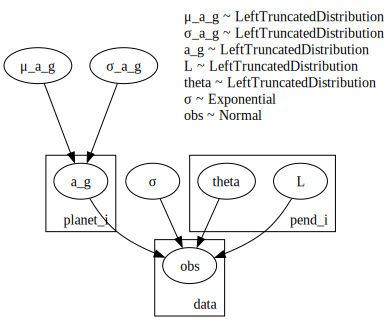

In [30]:
print(hierarchical_model)
## first hierarchical
numpyro.render_model(
    model=hierarchical_model,
    model_args=(df['planet_code'].values,
                df['pendulum_code'].values,
                df['time'].values,
                exponential),
    render_distributions=True,
    render_params=True,
)

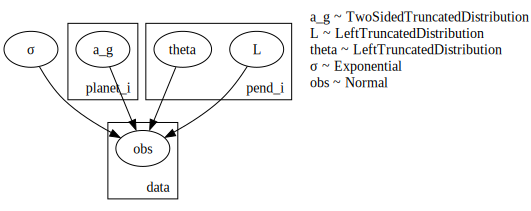

In [31]:
## unpooled
numpyro.render_model(
    model=unpooled_model,
    model_args=(df['planet_code'].values,
                df['pendulum_code'].values,
                df['time'].values,
                exponential),
    render_distributions=True,
    render_params=True,
)

## Prior predictive distribution
Before running anything, investigate what the prior predictive distribution looks like. This is a way of drawing from the priors that you have set up to see if they are reasonable compared to the data.

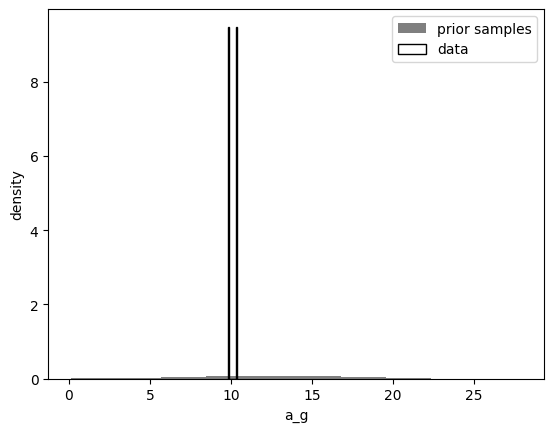

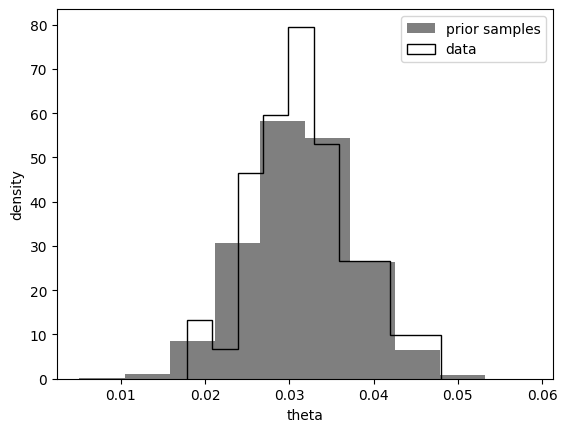

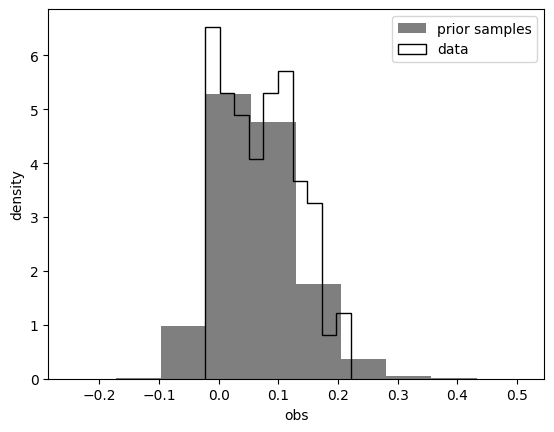

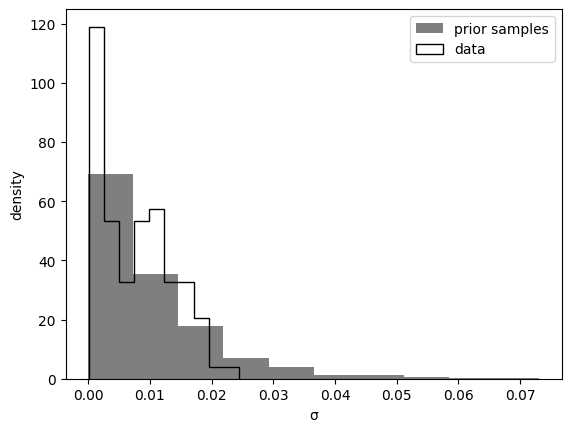

In [35]:
## generate samples from the prior using numpyro.infer.Predictive
## we will give it all the same inputs as the dataset, but this could be done with
## a new dataset

prior_pred = numpyro.infer.Predictive(hierarchical_model, num_samples=1000)(
    jax.random.PRNGKey(11), df['planet_code'].values,
                df['pendulum_code'].values,
                df['time'].values,
                exponential,
)

## the plot_prior_predictive helper graph function normalizes the density
## of the true and sampled parameter values so that they each sum to one
#plot_prior_predictive(prior_pred, "L", "length", n_steps=10, title = None)
utils.plot_prior_predictive(prior_pred, df, "a_g", "a_g", n_steps=10, title = None)
utils.plot_prior_predictive(prior_pred, df, "theta", "theta", n_steps=10, title = None)
utils.plot_prior_predictive(prior_pred, df, "obs", "pos", n_steps=10, title = None)
utils.plot_prior_predictive(prior_pred, df, "σ", "pos_err", n_steps=10, title = None)


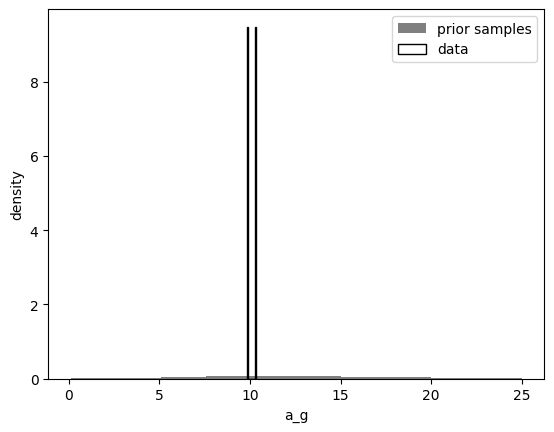

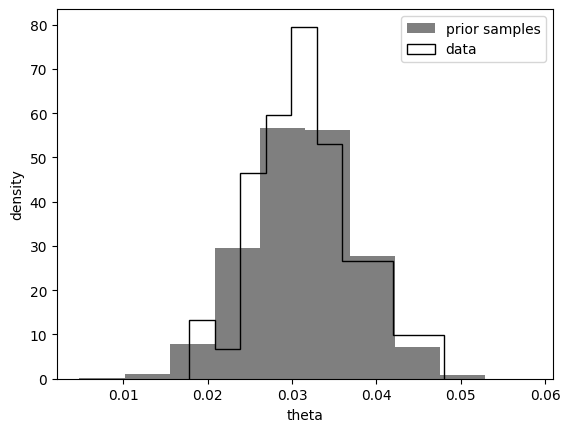

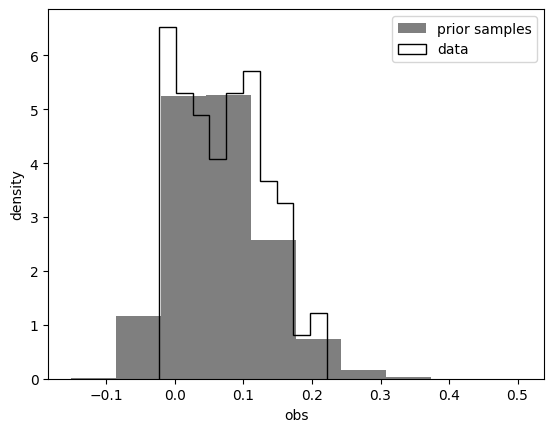

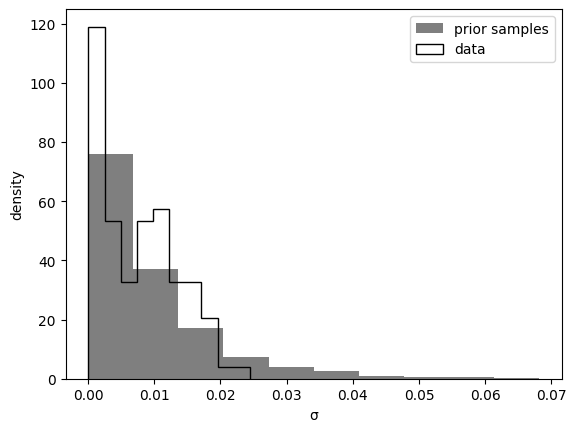

In [36]:
# same but for unpooled model

prior_pred = numpyro.infer.Predictive(unpooled_model, num_samples=1000)(
    jax.random.PRNGKey(11), df['planet_code'].values,
                df['pendulum_code'].values,
                df['time'].values,
                exponential,
)

## the plot_prior_predictive helper graph function normalizes the density
## of the true and sampled parameter values so that they each sum to one
#plot_prior_predictive(prior_pred, "L", "length", n_steps=10, title = None)
utils.plot_prior_predictive(prior_pred, df, "a_g", "a_g", n_steps=10, title = None)
utils.plot_prior_predictive(prior_pred, df, "theta", "theta", n_steps=10, title = None)
utils.plot_prior_predictive(prior_pred, df, "obs", "pos", n_steps=10, title = None)
utils.plot_prior_predictive(prior_pred, df, "σ", "pos_err", n_steps=10, title = None)


## Run the inference for the hierarchical case

In [39]:
## the NUTS (no u-turn sampler) is a type of hamiltonian monte carlo
## method, meaning it knows about potential energy (think gradients)
nuts_kernel = NUTS(hierarchical_model, init_strategy = numpyro.infer.initialization.init_to_sample)#, target_accept_prob = 0.9)

# can change the target acceptance probability
# default is 0.8 80% 
mcmc_hierarchical = MCMC(nuts_kernel, num_samples=5000, num_warmup=100, num_chains = 4)
rng_key = jax.random.PRNGKey(0)
mcmc_hierarchical.run(rng_key, df['planet_code'].values,
                df['pendulum_code'].values,
                df['time'].values,
                exponential, pos_obs=df['pos'].values)

posterior_samples_hierarchical = mcmc_hierarchical.get_samples()

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

In [40]:
table, inf_data = utils.sampling_summary_table(mcmc_hierarchical)
table

divergences: 178


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[0],5.013,1.938,1.294,8.578,0.068,0.048,793.0,864.0,1.01
L[1],5.132,1.939,1.488,8.659,0.068,0.048,821.0,1222.0,1.01
L[2],5.087,1.897,1.427,8.524,0.076,0.054,595.0,620.0,1.01
L[3],5.051,1.935,1.497,8.693,0.063,0.045,894.0,837.0,1.00
L[4],5.093,1.933,1.321,8.595,0.066,0.047,831.0,689.0,1.00
...,...,...,...,...,...,...,...,...,...
theta[98],0.032,0.006,0.020,0.043,0.000,0.000,3002.0,3480.0,1.00
theta[99],0.031,0.006,0.019,0.043,0.000,0.000,4065.0,4151.0,1.00
μ_a_g,13.646,4.758,4.844,22.645,0.515,0.365,85.0,214.0,1.04
σ,0.009,0.009,0.000,0.025,0.001,0.001,46.0,110.0,1.03


A few things to check here - you want to look at the effective sample size (ess_bulk and ess_tail). This number tells you how many HMC samples are independent; you want this number to close to the total number of samples.

In [ ]:
utils.investigate_distribution_posteriors(posterior_samples_hierarchical, inf_data)

## Interpreting the arviz table
The first two columns are the mean and standard deviation of each parameter, taken from examining all four chains.

- hdi = the high density interval, which is the minimum width Bayesian credible interval (BCI)

The best description I've found for it:

The HDI is the interval which contains the required mass such that all points within the interval have a higher probability density than points outside the interval. In contrast, a symmetric density interval defined by (eg.) the 10% and 90% quantiles may include values with lower probability than those excluded.


- mcse = markov chain standard error

- ess = effective sample size

This is equal to the sample size if all samples are independent. Here, the values are quite low for the different parameters, which indicates that we have very few indpendent draws. Does this mean we need to length the chains? Maybe.

- rhat = rank normalized splitR-hat for a set of traces (https://arxiv.org/pdf/1903.08008.pdf)

The rank normalized R-hat diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.

rhat ~ sqrt(1 + Nchains/ESS), 


so ESS/Nchains ~ 1/2/(rhat - 1), which means that if rhat = 1.05 then ESS/Nchains = 10, which isn’t very big

<Figure size 640x480 with 0 Axes>

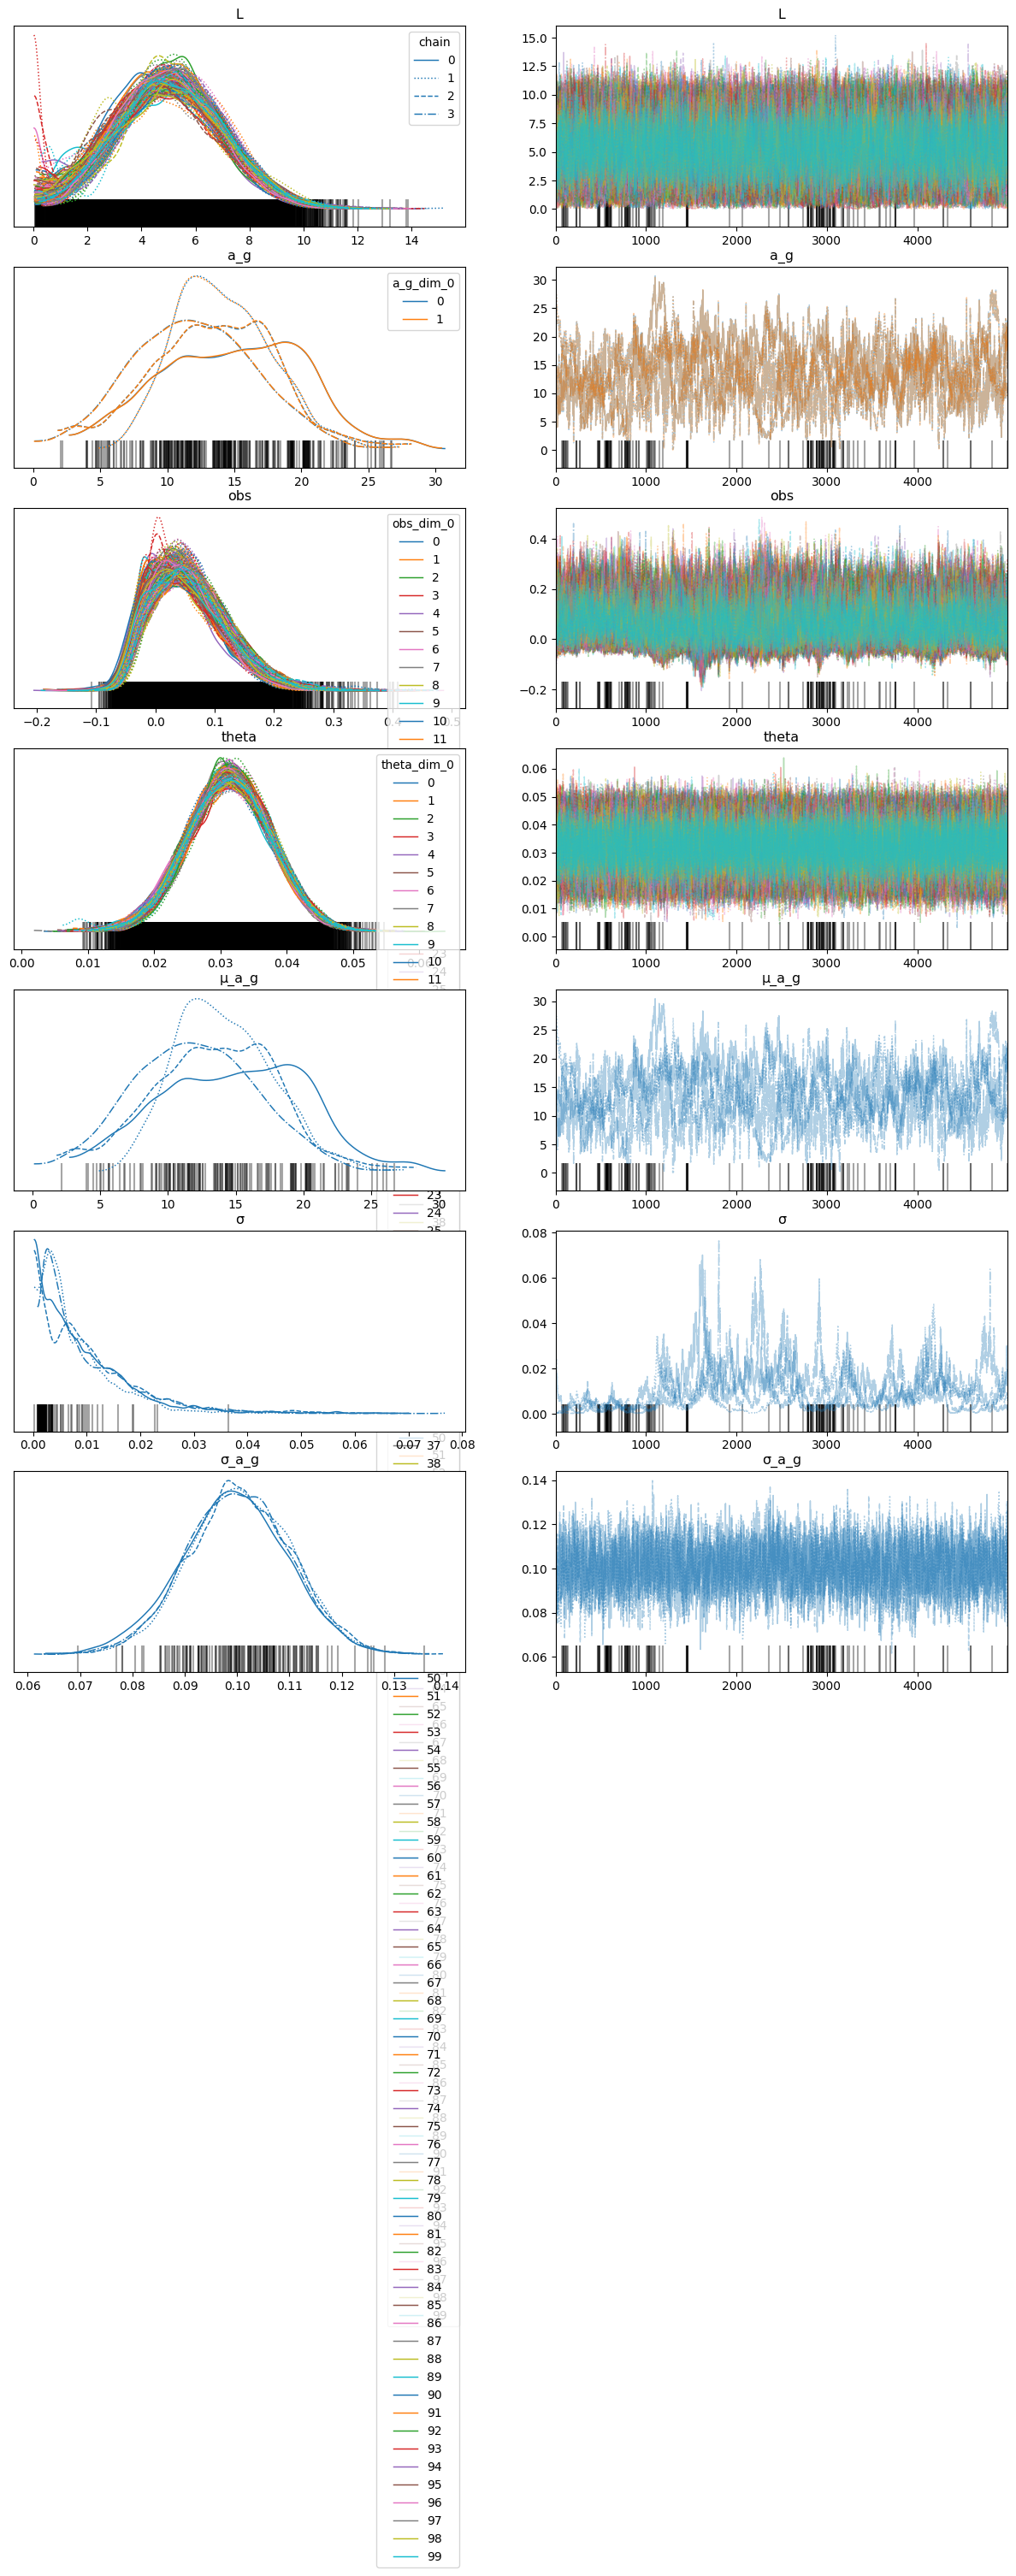

In [41]:
utils.az_trace(inf_data)

## Visualize it
Some of the classic ways to visualize the output don't work super well with a million pendulums

In [42]:
# so there are sampler chains for each group
print('shape of L samples', np.shape(mcmc_hierarchical.get_samples()['L']))
print('shape of a_g samples', np.shape(mcmc_hierarchical.get_samples()['a_g']))

shape of L samples (20000, 100)
shape of a_g samples (20000, 2)


In [43]:
# take a look at the posterior
utils.make_corner_plots(posterior_samples_hierarchical, )

NameError: name 'data_params' is not defined

In [ ]:
# Let's come up with a better way to show all seven pendulums sampling result in histogram form
# for the separate 4 chains
#def examine_chains(posterior, data_params, n_pendulums = 8, chain_length = 5000, n_chains = 4):

utils.examine_chains(posterior_samples_hierarchical, data_params)

In [ ]:
# how did we do at predicting the trajectory?
#how_did_we_do_on_individual_pendulums(df, posterior, 8, 2000)
utils.how_did_we_do_on_all_pendulums(df, posterior_samples_hierarchical, 8, 2000)

In [ ]:
# plot the posterior predictive samples
# get posterior predictive samples

hierarachical_posterior_predictive, hierarchical_posterior_predictive_samples, hierarchical_idata = plot_posterior_predictive_samples(df,
                                  hierarchical_model,
                                  posterior_hierarchical,
                                  rng_key,
                                  time_values,
                                  mcmc_hierarchical,
                                  pooled = False,
                                  title = "Hierarchical Model Posterior Predictive Check")

In [ ]:
# plot for each individual planet
print(hierarachical_posterior_predictive)
print(hierarchical_posterior_predictive_samples)
print(np.shape(posterior_hierarchical['L'][:,0]))


nbins = 20

plt.clf()
value, bin_center = np.histogram(hierarchical_posterior_predictive_samples['obs'].flatten()[:], bins = nbins)
plt.hist(hierarchical_posterior_predictive_samples['obs'].flatten()[:],
         bins = bin_center,
         color = '#6C969D', alpha = 0.5,
         label = 'Model posterior', 
         density = True,
         histtype='bar', ec='white')
plt.hist(df["pos"].values,
         bins = bin_center,
         color = '#99D5C9', alpha = 0.5,
         label = 'Obs',
         density = True,
         histtype='bar', ec='white')
plt.legend()
plt.show()

STOP
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 6), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for location in range(1, 2 + 1):
    ax = axes[location - 1]
    sns.histplot(
        x=hierarchical_posterior_predictive_samples["a_g"][:, location - 1],
        color=f"C{location - 1}",
        ax=ax,
    )
    ax.set(title=f"Planet {location}", xlabel="a_g", ylabel="count")

fig.suptitle("Hierarchical Model Prior Predictive Samples", y=1.05, fontsize=16)

## Now run the inference for the unpooled case

In [ ]:
# higher acceptance means smaller step size
# Target acceptance probability for step size adaptation using Dual Averaging. 
# Increasing this value will lead to a smaller step size, hence the sampling will be slower but more robust.
# Defaults to 0.8.
nuts_kernel_unpooled = NUTS(unpooled_model, init_strategy = numpyro.infer.initialization.init_to_sample)

mcmc_unpooled = MCMC(nuts_kernel_unpooled, num_samples=5000, num_warmup=100, num_chains = 4)
mcmc_unpooled.run(rng_key, planet_code, pend_code, times, exponential, pos_obs=pend_obs)

posterior_samples_unpooled = mcmc_unpooled.get_samples()

In [ ]:
table, inf_data = utils.sampling_summary_table(mcmc_unpooled)
table

In [ ]:
utils.az_trace(inf_data)

In [ ]:
# take a look at the posterior
utils.make_corner_plots(posterior_samples_unpooled, data_params)

## Lets compare the two models

One way to do comparisons is to look at the chains for each parameter.

In [ ]:
n_pendulums = 8
n_chains = 4
chain_length = 5000

fig, axs = plt.subplots(4, 2)

p = 0
for chain in range(n_chains):
    ax = axs[chain,0]
    
    ax.plot(posterior_samples_hierarchical['a_g'][chain_length * chain : chain_length * chain + chain_length-1 , p],
             label = f'chain {chain} hierarchical', alpha = 0.5, lw = 0.5,
             color = '#FF220C', 
)
    ax.axhline(y = data_params['a_g'][p], color = 'black')
    #ax.set_ylim([7,12])


    ax = axs[chain,1]
    
    ax.plot(posterior_samples_unpooled['a_g'][chain_length * chain : chain_length * chain + chain_length-1 , p],
             label = f'chain {chain} unpooled', alpha = 0.5, lw = 0.5,
             color = '#9B7874', 
)
    #break
    ax.axhline(y = data_params['a_g'][p], color = 'black')
    #ax.set_ylim([7,12])

    
fig.suptitle(f'a_g inference pendulum {p}')
#plt.legend()
plt.show()

fig, axs = plt.subplots(4, 2)


for chain in range(n_chains):
    ax = axs[chain,0]
    
    ax.plot(posterior_samples_hierarchical['theta'][chain_length * chain : chain_length * chain + chain_length-1 , p],
             label = f'chain {chain} hierarchical', alpha = 0.5, lw = 0.5,
             color = '#FF220C', 
)
    ax.axhline(y = data_params['theta'][p], color = 'black')
    ax.set_ylim([1*jnp.pi/200, 3*jnp.pi/200])


    ax = axs[chain,1]
    
    ax.plot(posterior_samples_unpooled['theta'][chain_length * chain : chain_length * chain + chain_length-1 , p],
             label = f'chain {chain} unpooled', alpha = 0.5, lw = 0.5,
             color = '#9B7874', 
)
    #break
    ax.axhline(y = data_params['theta'][p], color = 'black')
    ax.set_ylim([1*jnp.pi/200, 3*jnp.pi/200])

fig.suptitle(f'theta inference pendulum {p}')
#plt.legend()
plt.show()

My interpretation is that the chains are offset for many of the parameters.

In [ ]:
# What is a posterior predictive check?
# comparing the cumulative x positions from the data to those generated from 
# the posterior distribution
# some say this is using the data twice - 1. to generate the thetas, 2. to check again
utils.compare_models(unpooled_idata, unpooled_idata, hierarchical_idata, kind = 'cumulative')

In [ ]:
utils.compare_corner(posterior_samples_hierarchical, posterior_samples_unpooled, data_params)

Comparing the posterior distributions of $a_g$ for the two groupings (planets); let's look at the 1D ones

In [ ]:
print(np.shape(posterior_samples_unpooled['a_g']))
'''
p3 = np.percentile(posterior_samples['L'][:,num], 3)
        p97 = np.percentile(posterior_samples['L'][:,num], 97)
'''
xbins, bins = np.histogram(posterior_samples_unpooled['a_g'][:,0], bins = 100)
plt.hist(posterior_samples_hierarchical['a_g'][:,0], alpha = 0.5,
         label = 'Hierarchical', color = '#FF220C',
         bins = bins)
plt.hist(posterior_samples_unpooled['a_g'][:,0], alpha = 0.5,
         label = 'Unpooled', color = '#9B7874',
         bins = bins)

plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,0], 50), color = '#FF220C')
plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,0], 15.9), color = '#FF220C', ls = '--')
plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,0], 84.1), color = '#FF220C', ls = '--')


plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,0], 50), color = '#9B7874')
plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,0], 15.9), color = '#9B7874', ls = '--')
plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,0], 84.1), color = '#9B7874', ls = '--')


plt.axvline(x = 10.0, color = 'black')
plt.legend()
plt.title('$a_g$ planet 1 (1$\sigma$)')
plt.show()

In [ ]:
print(np.shape(posterior_samples_unpooled['a_g']))
print(posterior_samples_unpooled['a_g'][:,1],
      np.percentile(posterior_samples_unpooled['a_g'][:,1], 50),
      np.mean(posterior_samples_unpooled['a_g'][:,1]))

'''
p3 = np.percentile(posterior_samples['L'][:,num], 3)
        p97 = np.percentile(posterior_samples['L'][:,num], 97)
'''
xbins, bins = np.histogram(posterior_samples_unpooled['a_g'][:,1], bins = 100)
plt.hist(posterior_samples_hierarchical['a_g'][:,1], alpha = 0.5,
         label = 'Hierarchical', color = '#FF220C',
         bins = bins)
plt.hist(posterior_samples_unpooled['a_g'][:,1], alpha = 0.5,
         label = 'Unpooled', color = '#9B7874',
         bins = bins)

plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,1], 50), color = '#FF220C')
plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,1], 15.9), color = '#FF220C', ls = '--')
plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,1], 84.1), color = '#FF220C', ls = '--')


plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,1], 50), color = '#9B7874')
plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,1], 15.9), color = '#9B7874', ls = '--')
plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,1], 84.1), color = '#9B7874', ls = '--')


plt.axvline(x = 15.0, color = 'black')
plt.legend()
plt.title('$a_g$ planet 1 (1$\sigma$)')
plt.show()

Okay but how does this compare to the expected error?

In [ ]:
xbins, bins = np.histogram(posterior_samples_hierarchical['σ'], bins = 100)


plt.hist(df['pos_err'].values, bins = bins, alpha = 0.5, density = True, label = 'data')
plt.hist(posterior_samples_hierarchical['σ'], bins = bins, alpha = 0.5, color = '#FF220C', density = True, label = 'hierarchical')
plt.hist(posterior_samples_unpooled['σ'], bins = bins, alpha = 0.5, color = '#9B7874', density = True, label = 'unpooled')
plt.xlabel('position error')
plt.legend();

# But how to compare the modeled positions to the true positions?
This is like a PPC but I want to do it by hand.

First I'll construct a df for each model.

In [ ]:
df_hierarchical = pd.DataFrame()
df_unpooled = pd.DataFrame()

df_hierarchical['L'] = np.repeat(5.0, len(df))
df_unpooled['L'] = np.repeat(5.0, len(df))

df_hierarchical['theta'] = np.percentile(posterior_samples_hierarchical['theta'],50, axis = 0)
df_unpooled['theta'] = np.percentile(posterior_samples_unpooled['theta'],50, axis = 0)

percentile_50_0 = np.percentile(posterior_samples_hierarchical['a_g'][:, 0], 50)
percentile_50_1 = np.percentile(posterior_samples_hierarchical['a_g'][:, 1], 50)

# Assign percentiles to specific elements of df_hierarchical['a_g']
index_half_len = len(df_hierarchical) // 2
df_hierarchical['a_g'] = percentile_50_0
df_hierarchical['a_g'][index_half_len:] = percentile_50_1

percentile_50_0 = np.percentile(posterior_samples_unpooled['a_g'][:, 0], 50)
percentile_50_1 = np.percentile(posterior_samples_unpooled['a_g'][:, 1], 50)

# Assign percentiles to specific elements of df_hierarchical['a_g']
index_half_len = len(df_unpooled) // 2
df_unpooled['a_g'] = percentile_50_0
df_unpooled['a_g'][index_half_len:] = percentile_50_1

#df_hierarchical['a_g'][:,len(df)/2 - 1] = np.percentile(posterior_samples_hierarchical['a_g'][:,0],50)
#df_hierarchical['a_g'][len(df)/2 - 1:-1] = np.percentile(posterior_samples_hierarchical['a_g'][:,1],50)

df_hierarchical['pos'] = df_hierarchical['L'].values * jnp.sin(df_hierarchical['theta'].values * \
                                                        jnp.cos(jnp.sqrt(df_hierarchical['a_g'].values / df_hierarchical['L'].values) * 0.75))

df_unpooled['pos'] = df_unpooled['L'].values * jnp.sin(df_unpooled['theta'].values * \
                                                        jnp.cos(jnp.sqrt(df_unpooled['a_g'].values / df_unpooled['L'].values) * 0.75))

df_hierarchical['pos_err'] = np.percentile(posterior_samples_hierarchical['σ'],50, axis = 0)
df_unpooled['pos_err'] = np.percentile(posterior_samples_unpooled['σ'],50, axis = 0)

print(df_hierarchical)
print(df_unpooled)

First thing to do is examine the true position compared to the estimated position and pos err.

In [ ]:
plt.clf()
plt.scatter(df_hierarchical['theta'].values, 
            df_hierarchical['pos'].values,
            color = '#FF220C',
            label = 'hierarchical')
plt.errorbar(df_hierarchical['theta'].values, 
            df_hierarchical['pos'].values,
            yerr = df_hierarchical['pos_err'].values,
            color = '#FF220C',
            ls = 'None')
plt.scatter(df_unpooled['theta'].values, 
            df_unpooled['pos'].values,
            color = '#9B7874',
            label = 'unpooled')
plt.errorbar(df_unpooled['theta'].values, 
            df_unpooled['pos'].values,
            yerr = df_unpooled['pos_err'].values,
            color = '#9B7874',
            ls = 'None')
plt.scatter(df['theta'].values,
            df['pos'].values,
            color = 'black',
            label = 'data')
plt.errorbar(df['theta'].values,
            df['pos'].values,
            yerr = df['pos_err'].values,
            color = 'black',
            ls = 'None')
plt.xlabel(r'$\theta_0$')
plt.ylabel('x position')
plt.legend()
plt.show()

Both models are essentially estimating the mean of both $a_g$ populations. Let's get a better idea by looking at the residuals of observed x position and the predicted x position.

In [ ]:
plt.clf()
plt.scatter(df_hierarchical['theta'].values, 
            df_hierarchical['pos'].values - df['pos'].values,
            color = '#FF220C',
            label = 'hierarchical')
plt.scatter(df_unpooled['theta'].values, 
            df_unpooled['pos'].values - df['pos'].values,
            color = '#9B7874',
            label = 'unpooled')
plt.xlabel(r'$\theta_0$')
plt.ylabel('residual x position')
plt.legend()
plt.show()

If we flip this on its side and look at the histogram, we see

In [ ]:
nbins = 30
plt.clf()
xbins, bins = np.histogram(df['pos'].values, bins = nbins)
plt.hist(df_hierarchical['pos'].values,
         bins = bins,
         color = '#FF220C',
         label = 'hierarchical',
         alpha = 0.5
        )
plt.hist(df_unpooled['pos'].values,
         bins = bins,
         color = '#9B7874',
         label = 'unpooled',
         alpha = 0.5
        )
plt.hist(df['pos'].values,
         bins = bins,
         color = 'black',
         label = 'data',
         histtype='step',
         fill = False
        )
plt.xlabel('x position')
plt.legend()
plt.show()

The histograms of x position look the same for all distributions because they are predicting the mean. This is why its important to look at point estimates as well.

Let's look at a different variable and how the predicted values and residuals trend with it.

In [ ]:
variable = 'a_g'
plt.clf()
plt.scatter(df_hierarchical[variable].values, 
            df_hierarchical['pos'].values,
            color = '#FF220C',
            label = 'hierarchical')
plt.errorbar(df_hierarchical[variable].values, 
            df_hierarchical['pos'].values,
            yerr = df_hierarchical['pos_err'].values,
            color = '#FF220C',
            ls = 'None')
plt.scatter(df_unpooled[variable].values, 
            df_unpooled['pos'].values,
            color = '#9B7874',
            label = 'unpooled')
plt.errorbar(df_unpooled[variable].values, 
            df_unpooled['pos'].values,
            yerr = df_unpooled['pos_err'].values,
            color = '#9B7874',
            ls = 'None')
plt.scatter(df[variable].values,
            df['pos'].values,
            color = 'black',
            label = 'data')
plt.errorbar(df[variable].values,
            df['pos'].values,
            yerr = df['pos_err'].values,
            color = 'black',
            ls = 'None')
plt.xlabel(variable)
plt.ylabel('x position')
plt.legend()
plt.show()

In [ ]:
plt.clf()
plt.scatter(df_hierarchical[variable].values, 
            df_hierarchical['pos'].values - df['pos'].values,
            color = '#FF220C',
            label = 'hierarchical')
plt.scatter(df_unpooled[variable].values, 
            df_unpooled['pos'].values - df['pos'].values,
            color = '#9B7874',
            label = 'unpooled')
plt.xlabel(variable)
plt.ylabel('residual x position')
plt.legend()
plt.show()